In [1]:
%matplotlib inline

In [6]:
from pathlib import Path
import requests

DATA_PATH = Path("dataset")
PATH = DATA_PATH / "mnist"

PATH.mkdir(exist_ok=True, parents=True)

URL = "http://yann.lecun.com/exdb/mnist/"
FILENAME = "mnist.pkl.gz"

FILENAMES = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz",
]

for filename in FILENAMES:
    file_path = PATH / filename
    if not file_path.exists():
        response = requests.get(URL + filename)
        file_path.open("wb").write(response.content)

In [12]:
import numpy as np
import pickle
from pathlib import Path


def load_mnist_uncompressed(path, kind="train"):
    """Load MNIST data from uncompressed files in `path`"""
    labels_path = Path(path) / f"{kind}-labels-idx1-ubyte"
    images_path = Path(path) / f"{kind}-images-idx3-ubyte"

    with open(labels_path, "rb") as lbpath:
        lbpath.read(8)  # Skip the magic number and number of items
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, "rb") as imgpath:
        imgpath.read(16)  # Skip the magic number, number of items, rows, and columns
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 28, 28)

    return images, labels


# Set paths
DATA_PATH = Path("dataset")
PATH = DATA_PATH / "mnist"
FILENAME = "mnist.pkl.gz"

# Load data
x_train, y_train = load_mnist_uncompressed(PATH, kind="train")
x_valid, y_valid = load_mnist_uncompressed(PATH, kind="t10k")

# Create gzipped pickle file
with open((PATH / FILENAME).as_posix(), "wb") as f:
    pickle.dump(((x_train, y_train), (x_valid, y_valid)), f)

print("MNIST dataset has been loaded and saved as a pickle file.")

MNIST dataset has been loaded and saved as a pickle file.


torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


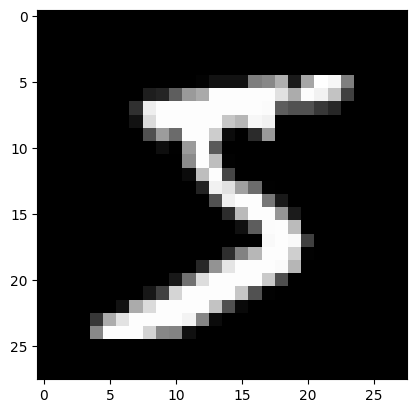

In [26]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")


x_train_flattened = x_train.view(60000, -1)
x_valid_flattened = x_valid.view(10000, -1)

# x_train[0].shape
# 28 * 28 * 1

In [30]:
import torch

x_train_flattened, y_train, x_valid_flattened, y_valid = map(
    torch.tensor, (x_train_flattened, y_train, x_valid_flattened, y_valid)
)

n, c = x_train_flattened.shape
x_train_flattened, x_train.shape, y_train.min(), y_train.max()

print(x_train_flattened, y_train)
print(x_train_flattened.shape)
print(y_train.min(), y_train.max())

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8) tensor([5, 0, 4,  ..., 5, 6, 8], dtype=torch.uint8)
torch.Size([60000, 784])
tensor(0, dtype=torch.uint8) tensor(9, dtype=torch.uint8)


/var/folders/qn/q_wdcf6x4kx5w2f12hyjr3700000gn/T/ipykernel_58125/518492739.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_flattened, y_train, x_valid_flattened, y_valid = map(


In [36]:
import torch.nn.functional as F

bs = 64
xb = x_train_flattened[0:bs].float()
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)

bs = 64
bias = torch.zeros(10, requires_grad=True)

# 分类
loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias


print(loss_func(model(xb), yb))

tensor(4428.1597, grad_fn=<NllLossBackward0>)


In [37]:
from torch import nn


class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 10)
      
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [38]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [39]:
for name, parameter in net.named_parameters():
  print(name, parameter, parameter.size())

hidden1.weight Parameter containing:
tensor([[-1.0353e-02,  1.6619e-03,  6.2858e-03,  ..., -2.8021e-02,
         -6.4393e-03, -4.6741e-03],
        [-2.7123e-02,  2.8797e-02, -8.7866e-03,  ...,  7.9236e-04,
          1.2759e-02, -1.2016e-02],
        [-2.1137e-02,  2.9402e-02, -3.3798e-02,  ...,  1.8542e-02,
          3.3231e-02, -2.3579e-02],
        ...,
        [ 9.3111e-03, -1.8097e-02, -2.1802e-02,  ..., -1.1664e-02,
         -1.4766e-03,  3.1759e-02],
        [-1.6731e-02, -2.5298e-02,  5.5864e-03,  ...,  3.1453e-02,
         -1.9730e-02,  1.2419e-02],
        [ 1.3195e-02, -2.1649e-02, -3.5688e-02,  ..., -6.3421e-03,
         -3.1510e-05,  3.4876e-02]], requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 0.0069, -0.0301,  0.0029,  0.0058, -0.0003,  0.0327,  0.0296,  0.0066,
         0.0044,  0.0331,  0.0011,  0.0287,  0.0158,  0.0306, -0.0344, -0.0231,
         0.0243, -0.0052,  0.0272, -0.0127, -0.0203, -0.0234, -0.0242, -0.0110,
         0.01

In [40]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train_flattened, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid_flattened, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True)

In [41]:
def get_data(train_ds, valid_ds, bs):
  return (
    DataLoader(train_ds, batch_size=bs, shuffle=True),
    DataLoader(valid_ds, batch_size=bs * 2),
  )

In [45]:
from torch import optim

def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [52]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [55]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb.float(), yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb.float(), yb) for xb, yb in valid_dl]
            )

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print("current step: " + str(step), "valid loss: " + str(val_loss))

In [56]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(steps=25, model=model, loss_func=loss_func, opt=opt, train_dl=train_dl, valid_dl=valid_dl)

current step: 0 valid loss: 0.2840849586546421
current step: 1 valid loss: 0.17690196447372436
current step: 2 valid loss: 0.15378171720951794
current step: 3 valid loss: 0.1779528607904911
current step: 4 valid loss: 0.14044759016558528
current step: 5 valid loss: 0.12547553565353156
current step: 6 valid loss: 0.12787932858504356
current step: 7 valid loss: 0.125582380111143
current step: 8 valid loss: 0.12037341888602823
current step: 9 valid loss: 0.1130837776163593
current step: 10 valid loss: 0.1149180659307167
current step: 11 valid loss: 0.11023953946456314
current step: 12 valid loss: 0.12379688370032237
current step: 13 valid loss: 0.11461072848513723
current step: 14 valid loss: 0.11098988030506297
current step: 15 valid loss: 0.10963634299160913
current step: 16 valid loss: 0.11364823824949563
current step: 17 valid loss: 0.11219032804258168
current step: 18 valid loss: 0.11926562459077686
current step: 19 valid loss: 0.11223635627606418
current step: 20 valid loss: 0.11292